# Practical Statistics for Data Scientists (Python)
# Chapter 7. Unsupervised Learning
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Import required Python packages.

In [1]:
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import prince

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

%matplotlib inline

DATA = Path('.').resolve().parents[1] / 'data'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [2]:
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'
SP500_SECTORS_CSV = DATA / 'sp500_sectors.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'
HOUSE_TASKS_CSV = DATA / 'housetasks.csv'

# Principal Components Analysis
## A simple example

In [3]:
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0)
oil_px = sp500_px[['XOM', 'CVX']]
print(oil_px.head())

                 XOM       CVX
1993-01-29 -0.016991  0.072921
1993-02-01  0.016991  0.102089
1993-02-02  0.084954  0.029168
1993-02-03  0.067964  0.058337
1993-02-04  0.034378  0.044272


In [4]:
pcs = PCA(n_components=2)
pcs.fit(oil_px)
loadings = pd.DataFrame(pcs.components_, columns=oil_px.columns)
print(loadings)

        XOM       CVX
0 -0.664711 -0.747101
1  0.747101 -0.664711


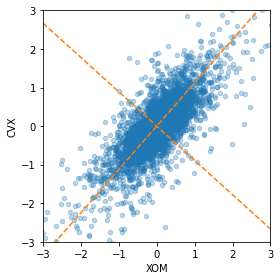

In [5]:
def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

ax = oil_px.plot.scatter(x='XOM', y='CVX', alpha=0.3, figsize=(4, 4))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.plot(*abline(loadings.loc[0, 'CVX'] / loadings.loc[0, 'XOM'], 0, ax),
        '--', color='C1')
ax.plot(*abline(loadings.loc[1, 'CVX'] / loadings.loc[1, 'XOM'], 0, ax),
        '--', color='C1')

plt.tight_layout()
plt.show()

## Interpreting principal components

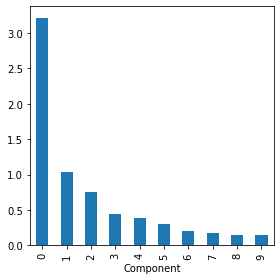

In [6]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
        'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]

sp_pca = PCA()
sp_pca.fit(top_sp)

explained_variance = pd.DataFrame(sp_pca.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

In [7]:
loadings = pd.DataFrame(sp_pca.components_[0:5, :], 
                        columns=top_sp.columns)
print(loadings)

       AAPL       AXP       COP      COST      CSCO       CVX        HD  \
0 -0.300825 -0.246332 -0.261529 -0.273634 -0.064059 -0.444490 -0.207983   
1 -0.505116 -0.139426  0.174212 -0.416307 -0.031939  0.289373 -0.278002   
2 -0.786730  0.135458 -0.002367  0.465862 -0.007524  0.082374  0.166320   
3 -0.120586  0.061814 -0.206026  0.092596  0.003904 -0.577665  0.162814   
4  0.111576 -0.596666 -0.005813  0.555529 -0.039860  0.109016 -0.185488   

       INTC       JPM      MSFT       SLB       TGT       USB       WFC  \
0 -0.076956 -0.196397 -0.105012 -0.481786 -0.148833 -0.116421 -0.145684   
1 -0.033898 -0.040723 -0.053954  0.472494 -0.228123 -0.054796 -0.047427   
2 -0.003518  0.062261  0.016248 -0.194822  0.160833  0.048976  0.041932   
3 -0.001605  0.057687 -0.012558  0.680914  0.109895  0.016752  0.018614   
4 -0.072047 -0.385160 -0.077135  0.181332 -0.055557 -0.155440 -0.216425   

        WMT       XOM  
0 -0.122304 -0.317952  
1 -0.222889  0.154192  
2  0.175806  0.090167  
3 

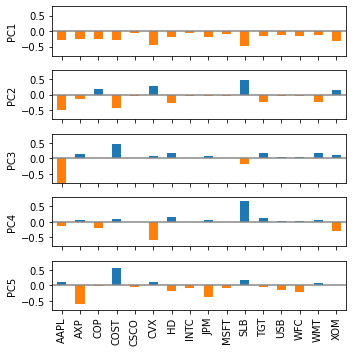

In [8]:
maxPC = 1.01 * np.max(np.max(np.abs(loadings.loc[0:5, :])))

f, axes = plt.subplots(5, 1, figsize=(5, 5), sharex=True)

for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

## Correspondence analysis

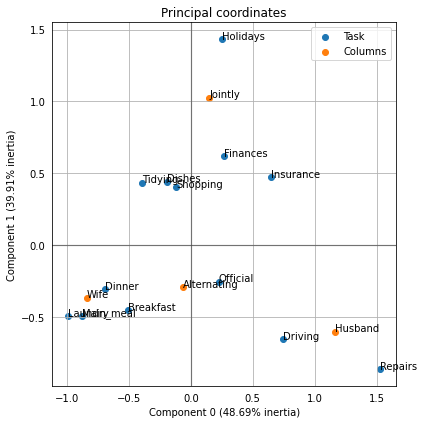

In [9]:
housetasks = pd.read_csv(HOUSE_TASKS_CSV, index_col=0)

ca = prince.CA(n_components=2)
ca = ca.fit(housetasks)

ca.plot_coordinates(housetasks, figsize=(6, 6))
plt.tight_layout()
plt.show()

# K-Means Clustering
## A Simple Example

In [10]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
kmeans = KMeans(n_clusters=4).fit(df)
df['cluster'] = kmeans.labels_
print(df.head())

                 XOM       CVX  cluster
2011-01-03  0.736805  0.240681        3
2011-01-04  0.168668 -0.584516        0
2011-01-05  0.026631  0.446985        3
2011-01-06  0.248558 -0.919751        0
2011-01-07  0.337329  0.180511        3


In [11]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['XOM', 'CVX'])
print(centers)

        XOM       CVX
0 -0.327313 -0.563098
1  0.962633  1.379702
2 -1.133502 -1.741985
3  0.243415  0.337513


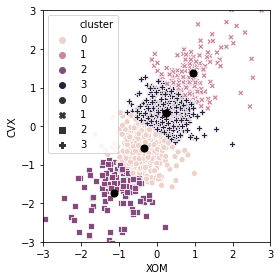

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.scatterplot(x='XOM', y='CVX', hue='cluster', style='cluster', 
                     ax=ax, data=df)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
centers.plot.scatter(x='XOM', y='CVX', ax=ax, s=50, color='black')

plt.tight_layout()
plt.show()

## K-Means Algorithm
The _scikit-learn_ algorithm is repeated 10 times by default (`n_init`), `max_iter` is used to control the number of iterations. 

In [13]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP', 
               'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]
kmeans = KMeans(n_clusters=5).fit(top_sp)

## Interpreting the Clusters

In [14]:
from collections import Counter
print(Counter(kmeans.labels_))

Counter({4: 301, 2: 290, 3: 250, 0: 187, 1: 103})


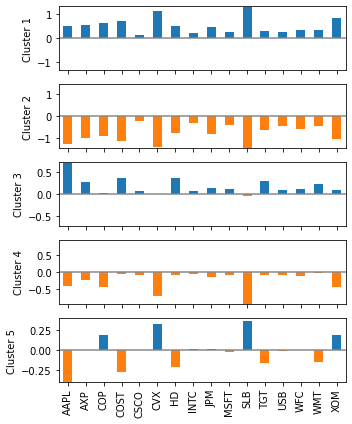

In [15]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=syms)

f, axes = plt.subplots(5, 1, figsize=(5, 6), sharex=True)
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.01 * np.max(np.max(np.abs(center)))
    colors = ['C0' if l > 0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i + 1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

## Selecting the Number of Clusters

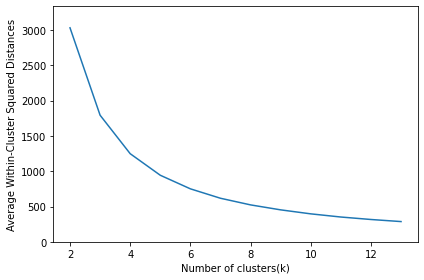

In [16]:
inertia = []
for n_clusters in range(2, 14):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(top_sp)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(2, 14), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

# Hierarchical Clustering
## A Simple Example

In [17]:
syms1 = ['AAPL', 'AMZN', 'AXP', 'COP', 'COST', 'CSCO', 'CVX', 'GOOGL', 'HD', 
         'INTC', 'JPM', 'MSFT', 'SLB', 'TGT', 'USB', 'WFC', 'WMT', 'XOM']
df = sp500_px.loc[sp500_px.index >= '2011-01-01', syms1].transpose()

Z = linkage(df, method='complete')
print(Z.shape)

(17, 4)


## The Dendrogram

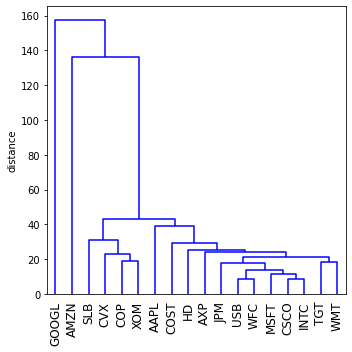

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))

dendrogram(Z, labels=df.index, color_threshold=0)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

plt.tight_layout()
plt.show()

In [19]:
memb = fcluster(Z, 4, criterion='maxclust')
memb = pd.Series(memb, index=df.index)
for key, item in memb.groupby(memb):
    print(f"{key} : {', '.join(item.index)}")

1 : COP, CVX, SLB, XOM
2 : AAPL, AXP, COST, CSCO, HD, INTC, JPM, MSFT, TGT, USB, WFC, WMT
3 : AMZN
4 : GOOGL


## Measures of Dissimilarity

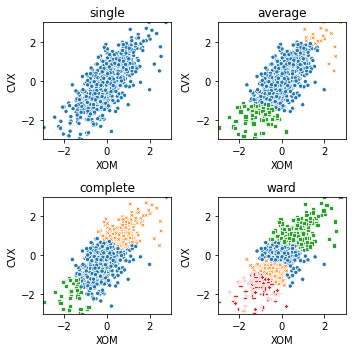

In [20]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
for i, method in enumerate(['single', 'average', 'complete', 'ward']):
    ax = axes[i // 2, i % 2]
    Z = linkage(df, method=method)
    colors = [f'C{c+1}' for c in fcluster(Z, 4, criterion='maxclust')]
    ax = sns.scatterplot(x='XOM', y='CVX', hue=colors, style=colors,
                         size=0.5, ax=ax, data=df, legend=False)

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_title(method)

plt.tight_layout()
plt.show()

# Model based clustering
## Multivariate Normal Distribution
> Define a colormap that corresponds to the probability levels

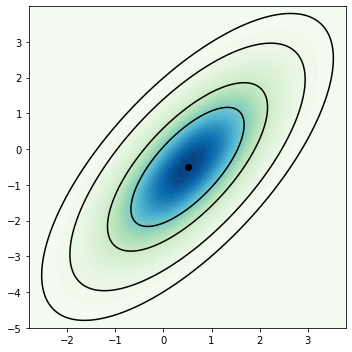

In [21]:
mean = [0.5, -0.5]
cov = [[1, 1], [1, 2]]
probability = [.5, .75, .95, .99]
def probLevel(p):
    D = 1
    return (1 - p) / (2 * math.pi * D)
levels = [probLevel(p) for p in probability]

fig, ax = plt.subplots(figsize=(5, 5))

x, y = np.mgrid[-2.8:3.8:.01, -5:4:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(mean, cov)


CS = ax.contourf(x, y, rv.pdf(pos), cmap=cm.GnBu, levels=50)
ax.contour(CS, levels=levels, colors=['black'])
ax.plot(*mean, color='black', marker='o')


plt.tight_layout()
plt.show()

## Mixtures of Normals

In [22]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
mclust = GaussianMixture(n_components=2).fit(df)
print(mclust.bic(df))

4589.259972552867


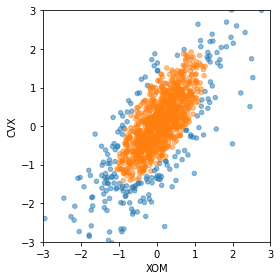

In [23]:
fig, ax = plt.subplots(figsize=(4, 4))
colors = [f'C{c}' for c in mclust.predict(df)]
df.plot.scatter(x='XOM', y='CVX', c=colors, alpha=0.5, ax=ax)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

In [24]:
print('Mean')
print(mclust.means_)
print('Covariances')
print(mclust.covariances_)

Mean
[[-0.0507743  -0.21582045]
 [ 0.07074619  0.10201778]]
Covariances
[[[0.98833257 0.99520038]
  [0.99520038 1.69955939]]

 [[0.2710052  0.27825521]
  [0.27825521 0.52175755]]]


## Selecting the number of clusters

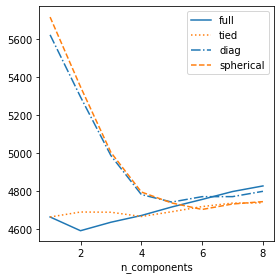

In [25]:
results = []
covariance_types = ['full', 'tied', 'diag', 'spherical']
for n_components in range(1, 9):
    for covariance_type in covariance_types:
        mclust = GaussianMixture(n_components = n_components, warm_start=True,
                                 covariance_type = covariance_type)
        mclust.fit(df)
        results.append({
            'bic': mclust.bic(df),
            'n_components': n_components,
            'covariance_type': covariance_type,
        })
        
results = pd.DataFrame(results)

colors = ['C0', 'C1', 'C2', 'C3']
styles = ['C0-','C1:','C0-.', 'C1--']

fig, ax = plt.subplots(figsize=(4, 4))
for i, covariance_type in enumerate(covariance_types):
    subset = results.loc[results.covariance_type == covariance_type, :]
    subset.plot(x='n_components', y='bic', ax=ax, label=covariance_type, 
                kind='line', style=styles[i]) # , color=colors[i])

plt.tight_layout()
plt.show()

# Scaling and Categorical Variables
## Scaling the Variables

In [26]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)
defaults = loan_data.loc[loan_data['outcome'] == 'default',]

columns = ['loan_amnt', 'annual_inc', 'revol_bal', 'open_acc', 
           'dti', 'revol_util']

df = defaults[columns]
kmeans = KMeans(n_clusters=4, random_state=1).fit(df)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=columns)
centers['size'] = [counts[i] for i in range(4)]
print(centers)

      loan_amnt     annual_inc     revol_bal   open_acc        dti  \
0  10637.693847   42631.523547  10320.622383   9.598871  17.704792   
1  22001.268591  167220.697288  39261.439195  12.593176  13.378101   
2  18318.495256   83980.990779  19769.353601  11.677669  16.766443   
3  22570.192308  489783.403846  85161.346154  13.326923   6.907500   

   revol_util   size  
0   58.148316  13974  
1   63.351943   1147  
2   62.310556   7498  
3   59.651923     52  


In [27]:
scaler = preprocessing.StandardScaler()
df0 = scaler.fit_transform(df * 1.0)

kmeans = KMeans(n_clusters=4, random_state=1).fit(df0)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=columns)
centers['size'] = [counts[i] for i in range(4)]
print(centers)

      loan_amnt     annual_inc     revol_bal   open_acc        dti  \
0  13466.944801   55898.294929  16405.578306  14.325738  24.202701   
1  10501.878203   51108.842190  11640.525627   7.508902  15.946078   
2  10319.056956   53440.614753   6044.048926   8.657516  11.285520   
3  25941.737057  116654.232970  32900.941144  12.391826  16.176403   

   revol_util  size  
0   59.387697  6240  
1   77.786191  7401  
2   30.987120  5345  
3   66.132281  3685  


## Dominant Variables

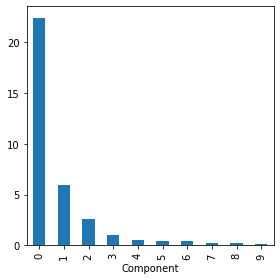

In [28]:
syms = ['GOOGL', 'AMZN', 'AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 
        'SLB', 'COP', 'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST']
top_sp1 = sp500_px.loc[sp500_px.index >= '2005-01-01', syms]

sp_pca1 = PCA()
sp_pca1.fit(top_sp1)

explained_variance = pd.DataFrame(sp_pca1.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

In [29]:
loadings = pd.DataFrame(sp_pca1.components_[0:2, :], 
                        columns=top_sp1.columns)
print(loadings.transpose())

              0         1
GOOGL -0.857310  0.477873
AMZN  -0.444728 -0.874149
AAPL  -0.071627 -0.020802
MSFT  -0.036002 -0.006204
CSCO  -0.029205 -0.003045
INTC  -0.026666 -0.006069
CVX   -0.089548 -0.037420
XOM   -0.080336 -0.020511
SLB   -0.110218 -0.030356
COP   -0.057739 -0.024117
JPM   -0.071228 -0.009244
WFC   -0.053228 -0.008597
USB   -0.041670 -0.005952
AXP   -0.078907 -0.024027
WMT   -0.040346 -0.007141
TGT   -0.063659 -0.024662
HD    -0.051412 -0.032922
COST  -0.071403 -0.033826


## Categorical Data and Gower's Distance
> Currently not available in any of the standard packages. However work is in progress to add it to scikit-learn. We will update this notebook once it becomes available

https://github.com/scikit-learn/scikit-learn/pull/9555/

In [30]:
x = defaults[['dti', 'payment_inc_ratio', 'home_', 'purpose_']].loc[0:4, :]
print(x)

     dti  payment_inc_ratio home_            purpose_
0   1.00            2.39320  RENT      major_purchase
1   5.55            4.57170   OWN      small_business
2  18.08            9.71600  RENT               other
3  10.08           12.21520  RENT  debt_consolidation
4   7.06            3.90888  RENT               other


```

###############################################################
## Figure 7-13: Categorical data and Gower's distance

x <- loan_data[1:5, c('dti', 'payment_inc_ratio', 'home_', 'purpose_')]
x

daisy(x, metric='gower')

set.seed(301)
df <- loan_data[sample(nrow(loan_data), 250),
                c('dti', 'payment_inc_ratio', 'home_', 'purpose_')]
d = daisy(df, metric='gower')
hcl <- hclust(d)
dnd <- as.dendrogram(hcl)

png(filename=file.path(PSDS_PATH, 'figures', 'psds_0713.png'), width = 4, height=4, units='in', res=300)
par(mar=c(0,5,0,0)+.1)
plot(dnd, leaflab='none', ylab='distance')
dev.off()

dnd_cut <- cut(dnd, h=.5)
df[labels(dnd_cut$lower[[1]]),]


## Problems in clustering with mixed data types
df <- model.matrix(~ -1 + dti + payment_inc_ratio + home_ + pub_rec_zero, data=defaults)
df0 <- scale(df)
km0 <- kmeans(df0, centers=4, nstart=10)
centers0 <- scale(km0$centers, center=FALSE, scale=1/attr(df0, 'scaled:scale'))
round(scale(centers0, center=-attr(df0, 'scaled:center'), scale=FALSE), 2)
```

## Problems with Clustering Mixed Data

In [31]:
columns = ['dti', 'payment_inc_ratio', 'home_', 'pub_rec_zero']
df = pd.get_dummies(defaults[columns])

scaler = preprocessing.StandardScaler()

df0 = scaler.fit_transform(df * 1.0)
kmeans = KMeans(n_clusters=4, random_state=1).fit(df0)
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=df.columns)
print(centers)

         dti  payment_inc_ratio  pub_rec_zero  home__MORTGAGE     home__OWN  \
0  17.456244           8.422914  1.000000e+00    1.000000e+00 -6.938894e-17   
1  16.992128           9.105395  1.000000e+00   -1.110223e-16 -3.330669e-16   
2  17.197993           9.266666  9.179025e-01    9.436896e-16  1.000000e+00   
3  16.504955           8.064247 -4.440892e-16    5.156600e-01 -1.804112e-16   

     home__RENT  
0 -3.108624e-15  
1  1.000000e+00  
2 -6.661338e-16  
3  4.843400e-01  
